In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import numpy as np
import re
from sklearn.metrics import roc_curve, auc
from sklearn import cross_validation, ensemble, preprocessing, metrics


C:\Users\Student\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df=pd.read_csv('dataset/table4.csv') # 載入資料

In [ ]:
df.columns

In [50]:
df_10k = df[df.loc[:,'user']<1001]
df_10k.shape

(20507, 34)

In [51]:
len(df_10k.loc[:,'user'].unique())

1000

In [ ]:
df_10k.to_csv('tb4_10k.csv',index = False)

In [ ]:
# df_10k=pd.read_csv('dataset/table3_10k.csv')

In [ ]:
df_10k.shape

In [ ]:
df_10k.head(5)

In [52]:
df_10k.isnull().any()

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x000001F8D31F54E0>>
Traceback (most recent call last):
  File "C:\Users\Student\Anaconda3\lib\site-packages\xgboost\core.py", line 482, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


user                    False
adgroup_id              False
pid                     False
cate_id                 False
campaign_id             False
customer                False
price                   False
cms_segid               False
cms_group_id            False
final_gender_code       False
age_level               False
pvalue_level            False
shopping_level          False
occupation              False
new_user_class_level    False
user_cate               False
pv_1                    False
cart_1                  False
fav_1                   False
buy_1                   False
pv_2                    False
cart_2                  False
fav_2                   False
buy_2                   False
pv_3                    False
cart_3                  False
fav_3                   False
buy_3                   False
brand_New               False
user_ad_pid             False
cnt_clk                 False
cnt_nonclk              False
cnt_percentage_total    False
click_or_n

In [53]:
df_10k.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20507 entries, 1216 to 23241613
Data columns (total 34 columns):
user                    20507 non-null int64
adgroup_id              20507 non-null int64
pid                     20507 non-null object
cate_id                 20507 non-null int64
campaign_id             20507 non-null int64
customer                20507 non-null int64
price                   20507 non-null float64
cms_segid               20507 non-null int64
cms_group_id            20507 non-null int64
final_gender_code       20507 non-null int64
age_level               20507 non-null int64
pvalue_level            20507 non-null int64
shopping_level          20507 non-null int64
occupation              20507 non-null int64
new_user_class_level    20507 non-null int64
user_cate               20507 non-null object
pv_1                    20507 non-null int64
cart_1                  20507 non-null int64
fav_1                   20507 non-null int64
buy_1                   20

In [ ]:
df_10k.columns

## 整理表格

In [54]:
df_10k = df_10k.drop('user_cate', axis = 1)
df_10k = df_10k.drop('user_ad_pid', axis = 1)
df_10k = df_10k.drop('cnt_percentage_total', axis = 1)
df_10k = df_10k.drop('cnt_clk', axis = 1)
df_10k = df_10k.drop('cnt_nonclk', axis = 1)
df_10k = df_10k.drop('pid', axis = 1)

In [ ]:
to_Obj =['user', 'adgroup_id', 'pid', 'cate_id', 'campaign_id', 'customer',
       'cms_segid', 'cms_group_id', 'final_gender_code', 'age_level',
       'pvalue_level', 'shopping_level', 'occupation', 'new_user_class_level',
       'brand_New', 'click_or_not']
for col in to_Obj:
    df_10k[col]=df_10k[col].astype(str)


In [55]:
to_int8 =['pv_1', 'cart_1',
       'fav_1', 'buy_1', 'pv_2', 'cart_2', 'fav_2', 'buy_2', 'pv_3', 'cart_3',
       'fav_3', 'buy_3']
for col in to_int8:
    df_10k[col]=df_10k[col].astype(np.int8)


In [56]:
df_10k.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20507 entries, 1216 to 23241613
Data columns (total 28 columns):
user                    20507 non-null int64
adgroup_id              20507 non-null int64
cate_id                 20507 non-null int64
campaign_id             20507 non-null int64
customer                20507 non-null int64
price                   20507 non-null float64
cms_segid               20507 non-null int64
cms_group_id            20507 non-null int64
final_gender_code       20507 non-null int64
age_level               20507 non-null int64
pvalue_level            20507 non-null int64
shopping_level          20507 non-null int64
occupation              20507 non-null int64
new_user_class_level    20507 non-null int64
pv_1                    20507 non-null int8
cart_1                  20507 non-null int8
fav_1                   20507 non-null int8
buy_1                   20507 non-null int8
pv_2                    20507 non-null int8
cart_2                  20507 non

### split to train/test/val

In [6]:
from sklearn.model_selection import train_test_split

In [ ]:
df_10k.head(5)

In [57]:
#split 'target' in df_train & df_test
x = df_10k.drop('click_or_not', axis = 1).values
y = df_10k['click_or_not'].values

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3)
divtest_x, val_x, divtest_y, val_y = train_test_split(test_x, test_y, test_size=0.5)

# XGBoost

In [58]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
xgb.__version__

'0.80'

In [59]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import decimal

In [ ]:
predictors = [x for x in train.columns]

In [19]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(x,y, test_size=0.3, random_state=1)

In [60]:
# 將資料存成xgboost要求的型態
data_train = xgb.DMatrix( train_x, label=train_y)
data_test  = xgb.DMatrix( test_x, label=test_y)
# xgtrain = xgb.DMatrix(train_x[predictors].values, label=train_y.values)

In [61]:
data_train

In [81]:
xgb_cl = XGBClassifier(scale_pos_weight=18,eval_metric='auc')

In [82]:
# model = xgb_cl.fit(train_x, train_y, eval_metric='auc')

#給予模型參數，告知演算法該如何訓練模型
param = {}
param['objective'] = 'reg:linear' # 做線性回歸
param['tree_method'] = 'hist'
param['silent']=1
param['max_depth']=5
eval_list  = [(data_train,'train'),(data_test,'test')]
num_round = 50
eval_history={}

# 訓練模型
model = xgb.train( param, data_train, num_round,eval_list,
                  evals_result=eval_history, verbose_eval=False)

[10:37:40] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


In [83]:
# testPredY = model.predict(data_train)
trainY_pred = model.predict(data_train)

In [75]:
trainY_pred

array([0.0869121 , 0.02638964, 0.07211601, ..., 0.04598191, 0.0298849 ,
       0.06231156], dtype=float32)

In [84]:
rmse_train=eval_history['train']['rmse']
rmse_test=eval_history['test']['rmse']

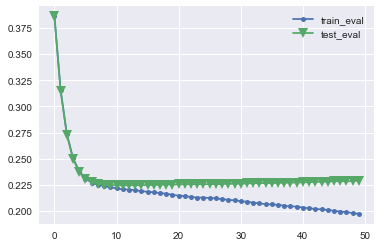

In [85]:
plt.plot(rmse_train,ms=10,marker='.',label='train_eval')
plt.plot(rmse_test,ms=10,marker='v',label='test_eval')
plt.legend()
plt.show()

In [86]:
print("AUC Score (Train): %f" % metrics.roc_auc_score(train_y, trainY_pred))

AUC Score (Train): 0.927405


In [89]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report


In [90]:
confusion_matrix(train_y, trainY_pred)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
# %%time

# #給予模型參數，告知演算法該如何訓練模型
# param = {}
# param['objective'] = 'binary:logistic' # 做線性回歸
# param['tree_method'] = 'hist'
# param['silent']=1
# param['max_depth']=10
# eval_list  = [(data_train,'train'),(data_test,'test')]
# num_round = 50
# eval_history={}

# # 訓練模型
# model = xgb.train( param, data_train, num_round,eval_list,
#                   evals_result=eval_history,verbose_eval=False)

In [ ]:
# df_10k['click_or_not']=df_10k['click_or_not'].astype(np.int8)

In [ ]:
train = df_10k
target = 'click_or_not'
IDcol = ''

In [ ]:
train.info()

In [ ]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob))
                    
        
        
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [ ]:
# Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb1, train, predictors)
